# Introduction

Word2Vec Skip-gram a été développé par Google. La documentation et les articles sont accessibles à l'adresse suivante :


*   https://code.google.com/archive/p/word2vec/


La librairie Gensim de Python permet d'accéder à des plongements lexicaux pré-entraînés ainsi que d'entraîner des modèles. La documentation est accessible à l'adresse suivante :


*   https://radimrehurek.com/gensim/index.html


Certains éléments du code implémenté dans le cadre de ce projet sont inspirés d'éléments des tutoriels que l'on peut retrouver aux adresses suivantes :


*   https://towardsdatascience.com/word2vec-from-scratch-with-numpy-8786ddd49e72
*   https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [0]:
import warnings

warnings.filterwarnings('ignore')

# Préparation des données

Téléchargement des corpus

In [0]:
import nltk

nltk.download('brown')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Génération de l'ensemble de données à partir des 10 premiers documents du corpus Brown

In [0]:
from nltk.corpus import brown

fileIDs = brown.fileids()[:10]
text = brown.sents(fileIDs)

In [0]:
from collections import Counter

def sentsToWords(sents):
  return [word for sent in sents for word in sent]

words = sentsToWords(text)
frequencies = Counter(words)

print('Avant le prétraitrement et le retrait des mots rares :\n')
print(f'Nombre de mots : {len(words)}')
print(f'Taille du vocabulaire : {len(frequencies)}')
print(f"Première phrase : {' '.join(text[0])}")

Avant le prétraitrement et le retrait des mots rares :

Nombre de mots : 22491
Taille du vocabulaire : 4696
Première phrase : The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced `` no evidence '' that any irregularities took place .


Prétraitement des données

In [0]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from time import time

def lowerText(sent):
  return list(map(lambda word: word.lower(), sent))

def removeNumbers(sent):
  return list(filter(lambda word: re.match(r'\d+', word) is None, sent))

def removePunctuation(sent):
  return list(filter(lambda word: re.match(r'[a-zA-Z]+', word) is not None, sent))

def removeStopWords(sent):
  stopWords = set(stopwords.words("english"))
  return list(filter(lambda word: word not in stopWords, sent))

def lemmatizeWords(sent):
  lemmatizer = WordNetLemmatizer()
  return list(map(lambda word: lemmatizer.lemmatize(word), sent))

def preprocessData(sents):
  sentences = list(map(lambda sent: lowerText(sent), sents))
  sentences = list(map(lambda sent: removeNumbers(sent), sentences))
  sentences = list(map(lambda sent: removePunctuation(sent), sentences))
  sentences = list(map(lambda sent: removeStopWords(sent), sentences))
  sentences = list(map(lambda sent: lemmatizeWords(sent), sentences))
  return sentences

start = time()
cleanText = preprocessData(text)
stop = time()

print(f'Temps pour effectuer le prétraitement : {round(stop - start, 2)} sec')

Temps pour effectuer le prétraitement : 0.25 sec


Retrait des mots rares

In [0]:
def removeRareWords(sents, min):
  words = sentsToWords(sents)
  frequencies = Counter(words)
  return list(map(lambda sent: list(filter(lambda word: frequencies[word] >= min, sent)), sents))

start = time()
data = removeRareWords(cleanText, 2)
stop = time()

print(f'Temps pour effectuer le retrait des mots rares : {round(stop - start, 2)} sec')

Temps pour effectuer le retrait des mots rares : 0.01 sec


In [0]:
dataWords = sentsToWords(data)
dataFrequencies = Counter(dataWords)

print('Après le prétraitrement et le retrait des mots rares :\n')
print(f'Nombre de mots : {len(dataWords)}')
print(f'Taille du vocabulaire : {len(dataFrequencies)}')
print(f"Première phrase : {' '.join(data[0])}")

Après le prétraitrement et le retrait des mots rares :

Nombre de mots : 9412
Taille du vocabulaire : 1665
Première phrase : fulton county grand jury said friday investigation atlanta's recent primary election evidence irregularity took place


# Entraînement des modèles

Entraînement d'un modèle Word2Vec Skip-gram avec numpy

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def mapWords(sents):
  word2index, index2word = {}, {}

  words = sentsToWords(sents)

  for index, word in enumerate(set(words)):
      word2index[word] = index
      index2word[index] = word

  return word2index, index2word

def generateSkipgrams(sents, word2index, windowSize):
  firstWords, secondWords = [], []
  
  for sent in sents:
    sentLength = len(sent)
    for i in range(sentLength):
      neighborIndexes = list(range(max(0, i - windowSize), i)) + list(range(i + 1, min(sentLength, i + windowSize + 1)))
      for j in neighborIndexes:
          firstWords.append(word2index[sent[i]])
          secondWords.append(word2index[sent[j]])
          
  firstWords = np.array(firstWords)
  firstWords = np.expand_dims(firstWords, axis=0)
  secondWords = np.array(secondWords)
  secondWords = np.expand_dims(secondWords, axis=0)
          
  return firstWords, secondWords

def initializeParameters(vocabSize, embSize):
  parameters = {}
  parameters['wordEmbs'] = np.random.randn(vocabSize, embSize) * 0.01
  parameters['denseMatrix'] = np.random.randn(vocabSize, embSize) * 0.01
  
  return parameters
    
def softmax(denseLayerOut):
  return np.divide(np.exp(denseLayerOut), np.sum(np.exp(denseLayerOut), axis=0, keepdims=True) + 0.001)

def forwardPropagation(indexes, parameters):
  wordEmbs = parameters['wordEmbs']
  wordVector = wordEmbs[indexes.flatten(), :].T
  denseMatrix = parameters['denseMatrix']
  denseLayerOut = np.dot(denseMatrix, wordVector)
  softmaxOut = softmax(denseLayerOut)
  
  caches = {}
  caches['indexes'] = indexes
  caches['wordVector'] = wordVector
  caches['denseMatrix'] = denseMatrix
  caches['denseLayerOut'] = denseLayerOut
  
  return softmaxOut, caches

def computeLoss(softmaxOut, trainDataLabel):
  return -(1 / softmaxOut.shape[1]) * np.sum(np.log(softmaxOut[trainDataLabel.flatten(), np.arange(trainDataLabel.shape[1])] + 0.001))

def computeGradients(trainDataLabel, softmaxOut, caches):
  denseMatrix = caches['denseMatrix']
  wordVector = caches['wordVector']

  softmaxOut[trainDataLabel.flatten(), np.arange(trainDataLabel.shape[1])] -= 1.0

  dLdOut = softmaxOut
  dLdDense = (1 / wordVector.shape[1]) * np.dot(dLdOut, wordVector.T)
  dLdWordVector = np.dot(denseMatrix.T, dLdOut)
  
  gradients = dict()
  gradients['dLdOut'] = dLdOut
  gradients['dLdDense'] = dLdDense
  gradients['dLdWordVector'] = dLdWordVector
  
  return gradients

def updateParameters(parameters, caches, gradients, learningRate):
  parameters['wordEmbs'][caches['indexes'].flatten(), :] -= gradients['dLdWordVector'].T * learningRate
  parameters['denseMatrix'] -= learningRate * gradients['dLdDense']

def numpyModelTraining(firstWords, secondWords, vocabSize, embSize, learningRate, epochs, batchSize):
  costs = []
  parameters = initializeParameters(vocabSize, embSize)
  
  start = time()

  for epoch in range(epochs):
      cost = 0
      batchIndexes = list(range(0, firstWords.shape[1], batchSize))
      np.random.shuffle(batchIndexes)

      for index in batchIndexes:
          firstWordBatch = firstWords[:, index:index+batchSize]
          secondWordBatch = secondWords[:, index:index+batchSize]
          softmaxOut, caches = forwardPropagation(firstWordBatch, parameters)
          loss = computeLoss(softmaxOut, secondWordBatch)
          gradients = computeGradients(secondWordBatch, softmaxOut, caches)
          updateParameters(parameters, caches, gradients, learningRate)
          cost += np.squeeze(loss)
          
      costs.append(cost)

      if epoch % (epochs // 100) == 0:
          learningRate *= 0.98

  stop = time()

  print(f'Temps pour entraîner le modèle : {round((stop - start) / 60, 2)} min\n')

  plt.rcParams['figure.figsize'] = (10.0, 8.0)
  plt.title('Fonction de coût de l\'entraînement de Skip-gram avec numpy')        
  plt.plot(np.arange(epochs), costs)
  plt.xlabel('Nombre d\'epochs')
  plt.ylabel('Coût')

  return parameters

Temps pour entraîner le modèle : 113.89 min



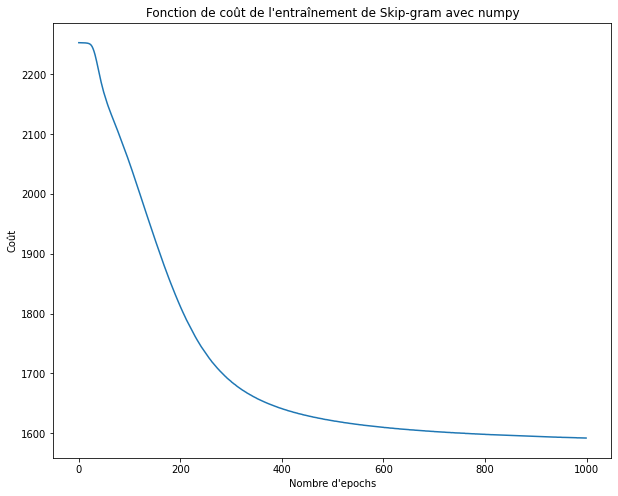

In [0]:
word2index, index2word = mapWords(data)
firstWords, secondWords = generateSkipgrams(data, word2index, 3)

vocabSize = len(index2word)

numpyModel = numpyModelTraining(firstWords, secondWords, vocabSize, 100, 0.05, 1000, 128)

Enregistrement des plongements lexicaux du modèle Word2Vec Skip-gram entraîné avec numpy

In [0]:
numpyVectors = {}

for index in np.arange(vocabSize):
  numpyVectors[index2word[index]] = numpyModel['wordEmbs'][index]

del numpyModel

Entraînement d'un modèle Word2Vec Skip-gram avec Gensim

Temps pour construire le vocabulaire : 0.35 sec
Temps pour entraîner le modèle : 1.14 min



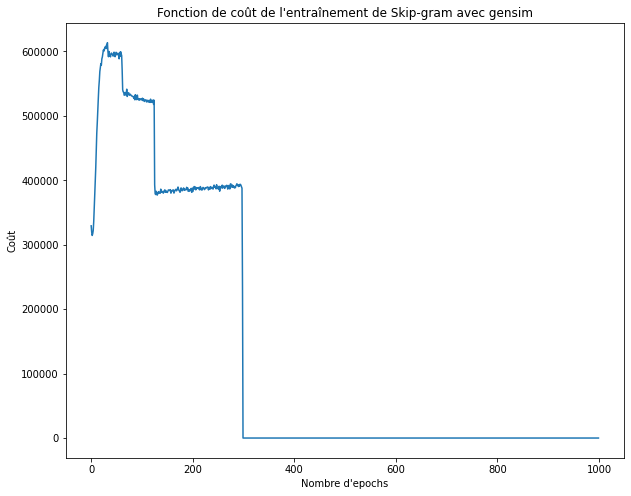

In [0]:
import multiprocessing
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

costs = []

class callback(CallbackAny2Vec):
  def __init__(self):
    self.epoch = 0
    self.cumulativeCost = 0

  def on_epoch_end(self, model):
    totalCost = model.get_latest_training_loss()
    epochCost = totalCost - self.cumulativeCost
    self.cumulativeCost = totalCost
    costs.append(epochCost)
    self.epoch += 1

nbCores = multiprocessing.cpu_count()

gensimModel = Word2Vec(sg=1,
                       hs=1,
                       min_count=2,
                       window=3,
                       size=100,
                       alpha=0.05, 
                       min_alpha=0.006,
                       workers=nbCores-1,
                       batch_words=128)

start = time()
gensimModel.build_vocab(data)
stop = time()

print(f'Temps pour construire le vocabulaire : {round(stop - start, 2)} sec')

start = time()
gensimModel.train(data,
                  total_examples=gensimModel.corpus_count,
                  epochs=1000,
                  compute_loss=True,
                  callbacks=[callback()])
stop = time()

print(f'Temps pour entraîner le modèle : {round((stop - start) / 60, 2)} min\n')

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.title('Fonction de coût de l\'entraînement de Skip-gram avec gensim')        
plt.plot(np.arange(1000), costs)
plt.xlabel('Nombre d\'epochs')
plt.ylabel('Coût')

gensimModel.wv.init_sims(replace=True)

Enregistrement des plongements lexicaux du modèle Word2Vec Skip-gram entraîné avec Gensim

In [0]:
gensimVectors = gensimModel.wv
del gensimModel

Téléchargement du modèle de référence

In [0]:
import gensim.downloader as api

googleModel = api.load('word2vec-google-news-300')

[=================================================-] 99.0% 1646.4/1662.8MB downloaded


Enregistrement des plongements lexicaux du modèle de référence

In [0]:
googleVectors = googleModel.wv
del googleModel

# Évaluation et comparaison des modèles

Capacité à trouver les 5 mots les plus similaires à 1 mot

In [0]:
from scipy import spatial

def getTopNMostSimilar(vectors, word, n):
  emb = vectors[word]
  embs = vectors.copy()
  del[embs[word]]
  topN = []

  for index in range(n):
    minDist = 2
    minWord = None
    for item in embs.items():
      dist = spatial.distance.cosine(emb, item[1])
      if dist < minDist:
        minDist = dist
        minWord = item[0]
    del[embs[minWord]]
    topN.append(minWord)
  
  return topN

def printTopNMostSimilar(ref, numpyResults, gensimResults, googleResults):
  print("Mots les plus semblables à {} avec numpy:".format(ref))
  for index, word in enumerate(numpyResults):
    print('{}. {}'.format(index + 1, word))

  print("\nMots les plus semblables à {} avec gensim:".format(ref))
  for index, word in enumerate(gensimResults):
    print('{}. {}'.format(index + 1, word[0]))

  print("\nMots les plus semblables à {} avec google:".format(ref))
  for index, word in enumerate(googleResults):
    print('{}. {}'.format(index + 1, word[0]))

In [0]:
words = ['president', 'organization', 'veteran']

for word in words:
  numpySimilar = getTopNMostSimilar(numpyVectors, word, 5)
  gensimSimilar = gensimVectors.similar_by_word(word, topn=5)
  googleSimilar = googleVectors.similar_by_word(word, topn=5)
  printTopNMostSimilar(word, numpySimilar, gensimSimilar, googleSimilar)
  print('\n')

Mots les plus semblables à president avec numpy:
1. known
2. opened
3. governor
4. told
5. association

Mots les plus semblables à president avec gensim:
1. retiring
2. considered
3. kennedy's
4. world
5. acting

Mots les plus semblables à president avec google:
1. President
2. chairman
3. vice_president
4. chief_executive
5. CEO


Mots les plus semblables à organization avec numpy:
1. assistance
2. philadelphia
3. genuine
4. north
5. reform

Mots les plus semblables à organization avec gensim:
1. technical
2. route
3. neutralist
4. end
5. reviewing

Mots les plus semblables à organization avec google:
1. organizations
2. organziation
3. organiztion
4. nonprofit_organization
5. organizaton


Mots les plus semblables à veteran avec numpy:
1. weary
2. approve
3. constitutional
4. board
5. construction

Mots les plus semblables à veteran avec gensim:
1. felix
2. agriculture
3. miller
4. principal
5. reporter

Mots les plus semblables à veteran avec google:
1. Veteran
2. verteran
3. vetera

Capacité à trouver le mot qui complète une relation entre deux mots

In [0]:
def completeRelation(vectors, pos1, neg1, pos2, n):
  ref = vectors[pos1] - vectors[neg1] + vectors[pos2]
  embs = vectors.copy()
  del[embs[pos1]]
  del[embs[neg1]]
  del[embs[pos2]]
  topN = []

  for index in range(n):
    minDist = 2
    minWord = None
    for item in embs.items():
      dist = spatial.distance.cosine(ref, item[1])
      if dist < minDist:
        minDist = dist
        minWord = item[0]
    del[embs[minWord]]
    topN.append(minWord)

  return topN

def printRelations(pos1, neg1, pos2, numpyResults, gensimResults, googleResults):
  print("Mots complètent le mieux la relation {}, {} -> {}, _ avec numpy :".format(pos1, neg1, pos2))
  for index, word in enumerate(numpyResults):
    print('{}. {}'.format(index + 1, word))

  print("\nMots complètent le mieux la relation {}, {} -> {}, _ avec gensim :".format(pos1, neg1, pos2))
  for index, word in enumerate(gensimResults):
    print('{}. {}'.format(index + 1, word[0]))

  print("\nMots complètent le mieux la relation {}, {} -> {}, _ avec google :".format(pos1, neg1, pos2))
  for index, word in enumerate(googleResults):
    print('{}. {}'.format(index + 1, word[0]))

In [0]:
relations = [('country', 'president', 'city'),
             ('georgia', 'state', 'atlanta' ),
             ('one', 'two', 'three'),
             ('hospital', 'doctor', 'school'),
             ('year', 'month', 'week'),
             ('supermarket', 'store', 'university'),
             ('september', 'month', 'thursday')]

for relation in relations:
  numpyRelation = completeRelation(numpyVectors, relation[1], relation[0], relation[2], 3)
  gensimRelation = gensimVectors.most_similar(positive=[relation[1], relation[2]], negative=[relation[0]], topn=3)
  googleRelation = googleVectors.most_similar(positive=[relation[1], relation[2]], negative=[relation[0]], topn=3)
  printRelations(relation[0], relation[1], relation[2], numpyRelation, gensimRelation, googleRelation)
  print('\n')

Mots complètent le mieux la relation country, president -> city, _ avec numpy :
1. criminal
2. name
3. pipeline

Mots complètent le mieux la relation country, president -> city, _ avec gensim :
1. operated
2. court
3. full-time

Mots complètent le mieux la relation country, president -> city, _ avec google :
1. mayor
2. Mayor
3. councilman


Mots complètent le mieux la relation georgia, state -> atlanta, _ avec numpy :
1. u.
2. called
3. le

Mots complètent le mieux la relation georgia, state -> atlanta, _ avec gensim :
1. united
2. jury
3. act

Mots complètent le mieux la relation georgia, state -> atlanta, _ avec google :
1. district
2. city
3. national


Mots complètent le mieux la relation one, two -> three, _ avec numpy :
1. explained
2. eastwick
3. spent

Mots complètent le mieux la relation one, two -> three, _ avec gensim :
1. nov.
2. years'
3. tuesday

Mots complètent le mieux la relation one, two -> three, _ avec google :
1. four
2. six
3. five


Mots complètent le mieux la r

Capacité à séparer les mots les plus similaires des mots les plus différents

In [0]:
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def getTopNLeastSimilar(vectors, word, n):
  emb = vectors[word]
  embs = vectors.copy()
  del[embs[word]]
  topN = []

  for index in range(n):
    maxDist = 0
    maxWord = None
    for item in embs.items():
      dist = spatial.distance.cosine(emb, item[1])
      if dist > maxDist:
        maxDist = dist
        maxWord = item[0]
    del[embs[maxWord]]
    topN.append(maxWord)
  
  return topN

def tsneScatterPlot(model, vectors, ref, similar, different):
  # Initialisation des arrays
  embs = np.empty((0, len(vectors[ref])), dtype='f')
  words = [ref]
  colors = ['blue']

  # Ajout du mot de référence
  emb = vectors[ref]
  embs = np.append(embs, emb.reshape(1, len(emb)), axis=0)

  # Ajout des mots similaires
  for word in similar:
    emb = vectors[word]
    words.append(word)
    colors.append('green')
    embs = np.append(embs, emb.reshape(1, len(emb)), axis=0)

  # Ajout des mots différents
  for word in different:
    emb = vectors[word]
    words.append(word)
    colors.append('red')
    embs = np.append(embs, emb.reshape(1, len(emb)), axis=0)

  # Réduction de la dimension avec PCA
  reducedEmbs = PCA().fit_transform(embs)

  # Trouver les coordonnées en 2 dimensions avec t-SNE
  np.set_printoptions(suppress=True)

  coordinates = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reducedEmbs)

  # Mise en forme pour l'affichage
  df = pd.DataFrame({'x': [x for x in coordinates[:, 0]],
                     'y': [y for y in coordinates[:, 1]],
                     'words': words,
                     'color': colors})

  fig, _ = plt.subplots()
  fig.set_size_inches(9, 9)

  # Graphique de base
  p1 = sns.regplot(data=df,
                   x="x",
                   y="y",
                   fit_reg=False,
                   marker="o",
                   scatter_kws={'s': 40,
                                'facecolors': df['color']
                               }
                  )

  # Annotations sur le graphique
  for line in range(0, df.shape[0]):
    p1.text(df["x"][line],
            df['y'][line],
            '  ' + df["words"][line].title(),
            horizontalalignment='left',
            verticalalignment='bottom', size='medium',
            color=df['color'][line],
            weight='normal'
           ).set_size(15)

  plt.xlim(coordinates[:, 0].min()-50, coordinates[:, 0].max()+50)
  plt.ylim(coordinates[:, 1].min()-50, coordinates[:, 1].max()+50)

  plt.title('Visualisation t-SNE pour {} avec {}'.format(ref.title(), model))

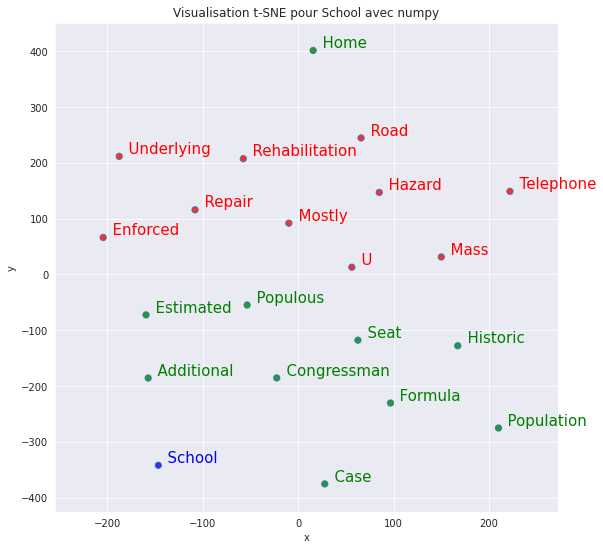

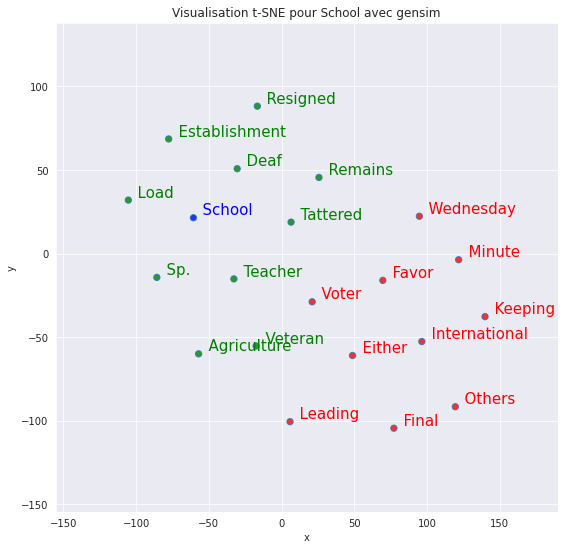

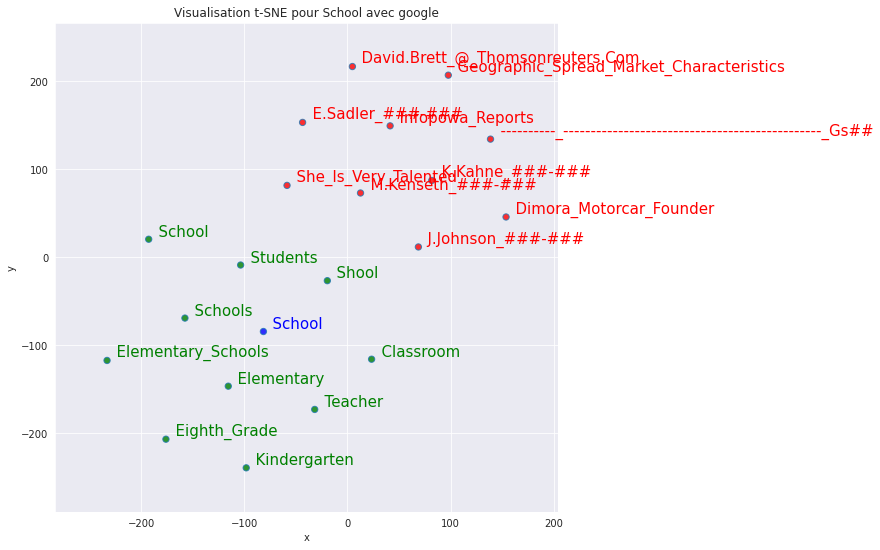

In [0]:
numpySim = getTopNMostSimilar(numpyVectors, 'school', 10)
gensimSim = gensimVectors.similar_by_word('school', topn=10)
googleSim = googleVectors.similar_by_word('school', topn=10)

numpyDiff = getTopNLeastSimilar(numpyVectors, 'school', 10)
gensimDiff = gensimVectors.most_similar(negative=['school'], topn=10)
googleDiff = googleVectors.most_similar(negative=['school'], topn=10)

tsneScatterPlot('numpy', numpyVectors, 'school', numpySim, numpyDiff)
tsneScatterPlot('gensim', gensimVectors, 'school', [i[0] for i in gensimSim], [i[0] for i in gensimDiff])
tsneScatterPlot('google', googleVectors, 'school', [i[0] for i in googleSim], [i[0] for i in googleDiff])